# Clasificación de células mamarias para el diagnóstico morfológico de cáncer de mama a través del ajuste de un Modelo de Regresión Logística


## Equipo de trabajo

1. Miriam Díaz Rodríguez
2. Marisol Flores Guerrero
3. Noé Salvador Hernández González
4. José Antonio Aviña Méndez 

## ¿Qué es el cáncer de mama?

El cáncer de mama se presenta, como un cuadro patalógico, cuando las células mamarias comienzan a crecer sin control. Las células cancerosas del seno suelen formar un tumor, el cual se puede observar en una radiografía. Más aún, dicho tumor puede detectarse, a través del tacto, como una masa o bulto. 

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as skl_lm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf


sns.set(style="whitegrid", color_codes=True, font_scale=1.3)
%matplotlib inline

## Fuentes de información y almacenamiento

El DataSet se obtuvo del *UCI Machine Learning Repository* (https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic). El formato de almacenamiento adoptado es *CSV*, el cuál es uno de los formatos más comunmente utilizados y apropiados para administrar DataSets.

In [97]:
# cargar los datos
data = pd.read_csv('data.csv', index_col=0)

print('Características del núcleo de las células y su respectivo diagnóstico:')
data.head()

Características del núcleo de las células y su respectivo diagnóstico:


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [98]:
# eliminar columna con faltantes
data = data.drop('Unnamed: 32', axis=1)

## Morfología de una célula de mama

A continuación se muestran la morfología normal de una célula, sana, de mama y una célula con alteraciones morfológicas sugestivas de cáncer de mama.


![Alt Text](cells.png)
Fig. 1: Morfología de la células mamarias. Adaptada de https://www.verywellhealth.com/what-does-malignant-and-benign-mean-514240


## Visualización de datos

Observaciones etiquetadas como Benignas:  357
Observaciones etiquetadas como Malignas :  212


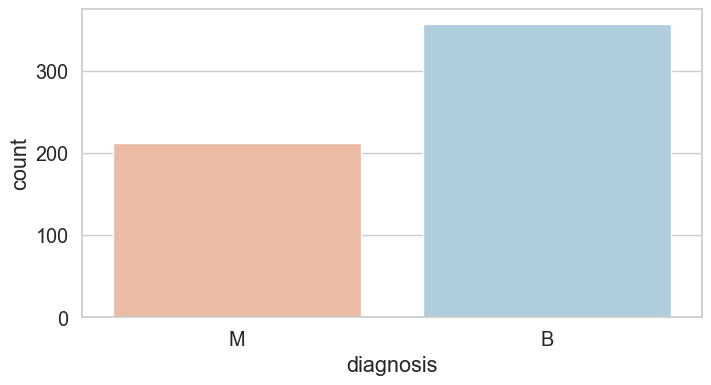

In [99]:
plt.figure(figsize=(8, 4))
sns.countplot(df['diagnosis'], palette='RdBu')

benignas, malignas = df['diagnosis'].value_counts()
print('Observaciones etiquetadas como Benignas: ', benignas)
print('Observaciones etiquetadas como Malignas : ', malignas)

In [100]:
# eliminar variables para conservar solo categórica y predictoras
cols = ['radius_worst', 
        'texture_worst', 
        'perimeter_worst', 
        'area_worst', 
        'smoothness_worst', 
        'compactness_worst', 
        'concavity_worst',
        'concave points_worst', 
        'symmetry_worst', 
        'fractal_dimension_worst']
data = data.drop(cols, axis=1)

cols = ['perimeter_mean',
        'perimeter_se', 
        'area_mean', 
        'area_se']
data = data.drop(cols, axis=1)

cols = ['concavity_mean',
        'concavity_se', 
        'concave points_mean', 
        'concave points_se']
data = data.drop(cols, axis=1)

print('Variables categórica y predictoras:')
data.columns

Variables categórica y predictoras:


Index(['diagnosis', 'radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se'],
      dtype='object')

## Segmentar el conjunto de datos para entrenamiento y prueba

In [101]:
predictoras = data
categorica = data['diagnosis']

predictoras_train, predictoras_test, categorica_train, categoria_test = train_test_split(predictoras, categorica, test_size=0.3, random_state=40)

## Aprendizaje y entrenamiento
El proceso de aprendizaje máquina consiste en un problema de optimización de una función objetivo (i.e. loss function). En este particular escenario se emplea como *loss function* la función **maximum likelihood** $L(\mathbf{\theta})$:


$$
L(\theta) =\prod_{i=1}^{N} \  p\left(y^{(i)} \mid \mathbf{x}^{(i)} ; \mathbf{\theta}\right)^{y^{(i)}}  * \ \ \ 
p\left(y^{(i)} \mid \mathbf{x}^{(i)} ; \mathbf{\theta}\right)^{1-y^{(i)}}
$$                                                                      


Sin embargo, para facilitar la solución del problema de optimización replanteamos la función likelihood en términos de lo que técnicamente se conoce como función **loglikelihood** $LL(\theta)$: 


 $$LL(\theta) =  J(\theta)=-\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(\log  p \left(y^{(i)} \mid \mathbf{x}^{(i)} ;  \mathbf{\theta}\right)^{y^{(i)}}  + \ \ \ \log \left(p\left(y^{(i)} \mid \mathbf{x}^{(i)} ; \mathbf{\theta}\right)^{1- y^{(i)}} \right)\right)\right]$$
 
 y es que ambas funciones convergen en el mismo máximo global como se puede apreciar en la Fig. 2:
 
![Alt Text](likeli-loglikeli.png)
Fig. 2: likelihood vs log(likelihood). Adaptada de https://www.aptech.com/blog/beginners-guide-to-maximum-likelihood-estimation-in-gauss/
 
 
### Simplificación y minimización de la loss function

Bien, renombremos $LL(\theta) = J(\theta)$ para proceder a minimizar la función loglikelihood $J(\theta)$. Ahora, para facilitar este proceso de minimización vamos a simplificar $J(\theta)$: 

### Simplificación de $J(\theta)$

Para simplificar nuestra loss function haremos recurso tanto a las leyes de los logaritmos como a simples manipulaciones algebraicas:

$$J(\theta)=-\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(\left(\log h_{\theta}\left(x^{(i)}\right)\right)^{y^{(i)}}+ \log \left(1-h_{\theta}\left(x^{(i)}\right)\right)^{\left(1-y^{(i)}\right)}\right)\right]$$

**apliquemos log power rule**

$$J(\theta)=-\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(y^{(i)}\left(\log h_{\theta}\left(x^{(i)}\right)\right)+\left(1-y^{(i)}\right) \log \left(1-h_{\theta}\left(x^{(i)}\right)\right)\right)\right]$$


**reemplacemos** $h_{\theta}\left(x^{(i)}\right)$ **por la función sigmoide**

$$=-\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(y^{(i)} \log \left(\frac{1}{1+e^{-\theta^{T} x^{(i)}}}\right)+\left(1-y^{(i)}\right) \log \left(1-\frac{1}{1+e^{-\theta^{T} x^{(i)}}}\right)\right)\right]$$


$$=-\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(y^{(i)} \log \left(\frac{1}{1+e^{-\theta^{T} x^{(i)}}}\right)+\left(1-y^{(i)}\right) \log \left(\frac{e^{-\theta^{T} x^{(i)}}}{1+e^{-\theta^{T} x^{(i)}}}\right)\right)\right]$$


**apliquemos quotient rule** $\log \left(\frac{a}{b}\right)=\log (a)-\log (b)$ 

$$=-\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(y^{(i)}\left(\log (1)-\log \left(1+e^{-\theta^{T} x^{(i)}}\right)\right)+\left(1-y^{(i)}\right) \log \left(\frac{e^{-\theta^{T} x^{(i)}}}{1+e^{-\theta^{T} x^{(i)}}}\right)\right)\right]$$

$$=-\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(-y^{(i)} \log \left(1+e^{-\theta^{T} x^{(i)}}\right)+\left(1-y^{(i)}\right) \log \left(\frac{e^{-\theta^{T} x^{(i)}}}{1+e^{-\theta^{T} x^{(i)}}}\right)\right)\right]$$


**apliquemos nuevamente quotient rule** $\log \left(\frac{a}{b}\right)=\log (a)-\log (b)$ 

$$=-\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(-y^{(i)} \log \left(1+e^{-\theta^{T} x^{(i)}}\right)+\left(1-y^{(i)}\right) \log \left(e^{-\theta^{T} x^{(i)}}\right)-\left(1-y^{(i)}\right)\left(\log \left(1+e^{-\theta^{T} x^{(i)}}\right)\right)\right]\right.$$

**apliquemos ahora** $\log \left(e^{a}\right)=a$ 

$$=-\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(-y^{(i)} \log \left(1+e^{-\theta^{T} x^{(i)}}\right)+\left(1-y^{(i)}\right)\left(-\theta^{T} x^{(i)}\right)-\left(1-y^{(i)}\right)\left(\log \left(1+e^{-\theta^{T} x^{(i)}}\right)\right)\right]\right.$$

**movamos el signo**

$$=\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(y^{(i)} \log \left(1+e^{-\theta^{T} x^{(i)}}\right)+\left(1-y^{(i)}\right)\left(\theta^{T} x^{(i)}\right)+\left(1-y^{(i)}\right)\left(\log \left(1+e^{-\theta^{T} x^{(i)}}\right)\right)\right]\right.$$


**factoricemos términos**

$$=\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(\log \left(1+e^{-\theta^{T} x^{(i)}}\right)+\left(1-y^{(i)}\right)\left(\theta^{T} x^{(i)}\right)\right)\right]$$


### Minimización de $J(\theta)$

$$\frac{\partial J(\theta)}{\partial \theta_{j}} =\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(\frac{e^{-\theta^{T} x^{(i)}}\left(-x_{j}^{(i)}\right)}{1+e^{-\theta^{T} x^{(i)}}}+\left(1-y^{(i)}\right) x_{j}^{(i)}\right)\right]$$

**usemos como factor común** $x^{(i)}_{j}$

$$=\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(\frac{-e^{-\theta^{T} x^{(i)}}}{1+e^{-\theta^{T} x^{(i)}}}+1-y^{(i)}\right) x_{j}^{(i)}\right]$$

**combinemos términos**

$$\left.=\frac{1}{m}\left[\sum\limits_{i=1}^{m}\left(\frac{1}{1+e^{-\theta^{T} x^{(i)}}}-y^{(i)}\right) x_{j}^{(i)}\right)\right]$$


Una vez optimizada la loss function podemos entonces construir la **Regla de Aprendizaje** que se empleará en el *Gradiente descenciente* para aprender (i.e. optimizar) los parámetros, $\theta_j$, del modelo:


$$ 
\theta_j^{new} = \theta_j^{old} - \alpha \cdot \sum\limits_{i=1}^{m}\left(\frac{1}{1+e^{-\theta^{T} x^{(i)}}}-y^{(i)}\right) x_{j}^{(i)}
$$

#### Solución del Sistema de Ecuaciones

Dado que $J(\theta)$ posee funciones trascendentes, el sistema de ecuaciones no posee una solución cerrada por lo que se recurre a una técnica iterativa de optimización, de primer orden, como el gradiente descendiente para aproximarnos a los valores óptimos de los parámetros, $\theta_j$, del modelo.

In [102]:
cols = data.columns.drop('diagnosis')
formula = 'diagnosis ~ ' + ' + '.join(cols)
modelo = smf.glm(formula=formula, data=predictoras_train, family=sm.families.Binomial())
modelo_aproximado = modelo.fit()

## Probabilidad Condicional
Una vez ajustado el modelo se procede prácticamente a calcular la probabilidad condicional, $(y|x,\theta)$, de que las observaciones -del subconjunto de prueba- pertenezcan a la clase Maligno o Benigno. 

In [103]:
predicciones = modelo_aproximado.predict(predictoras_test)

print('Probabilidad condicional para las primeras 10 observaciones del subconjunto de prueba:')
predicciones[1:10]

Probabilidad condicional para las primeras 10 observaciones del subconjunto de prueba:


id
848406      0.324251
907915      0.996906
911201      0.964710
84799002    0.000544
8911164     0.838719
9113156     0.609435
863031      0.967341
8711216     0.053005
865137      0.999907
dtype: float64

### Clasificación de tumores

In [106]:
tumores_clasificados = [ "maligno" if x < 0.5 else "benigno" for x in predicciones]

print('Primeros 10 tumores clasificados con el modelo aprendido (i.e. optimizado):')
tumores_clasificados[1:10]



Primeros 10 tumores clasificados con el modelo aprendido (i.e. optimizado):


['maligno',
 'benigno',
 'benigno',
 'maligno',
 'benigno',
 'benigno',
 'benigno',
 'maligno',
 'benigno']

### Interpretación de los resultados

Finalmente, dado el siguiente conjunto de valores de la probabilidad condicional $p(y|x,\theta)$ (i.e. predicciones): 


In [107]:
predicciones[1:10]

id
848406      0.324251
907915      0.996906
911201      0.964710
84799002    0.000544
8911164     0.838719
9113156     0.609435
863031      0.967341
8711216     0.053005
865137      0.999907
dtype: float64

**entonces**:

*Si $p(y|x,\theta) = 0.324251$, el tumor es maligno*

*Si $p(y|x,\theta) = 0.996906$, el tumor es benigno*

$\vdots$

*Si $p(y|x,\theta) =  0.053005$, el tumor es maligno*

*Si $p(y|x,\theta) = 0.999907$, el tumor es benigno*